# VAL AND MOM IN THE SAME PLACE (Work-in-Progress)

[@sparshsah](https://github.com/sparshsah)

## setup

// [commit when I decided to start over](https://github.com/sparshsah/foggy-demo/blob/2aa977b/demo/finance/val-and-mom-in-the-same-place.ipynb)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from foggy_statslib import core as fc

In [193]:
def _get_px_bridge(p0: float = 1, p1: float = 1, t0: int = 0, span: int=8) -> pd.Series:
    domain = range(t0, t0+span)
    if p0 == p1:
        bridge = pd.Series(p0, index=domain)
    elif p0 < p1:
        bridge = pd.Series(np.exp(domain))
        # standardize: tare and scale
        bridge = bridge - bridge.min()
        bridge = bridge / (bridge.max() - bridge.min())
        # customize: scale and tare
        bridge = bridge * (p1 - p0)
        bridge = bridge + p0
    else:  # flip
        bridge = _get_px_bridge(p1, p0, t0=t0, span=span)
        bridge = bridge.iloc[::-1]
        bridge.index = domain
    return bridge

## Empirical Background: Value and Momentum Everywhere

["Value and Momentum Everywhere" (Asness-Moskowitz-Pedersen 2013)](https://www.aqr.com/Insights/Research/Journal-Article/Value-and-Momentum-Everywhere) was a seminal contribution to liquid-alternative relative-value factor investing, in both single-name and macro securities.

The following cross-sectional pricing anomalies (based on backward-looking observed returns) tend to stand up across geographies (e.g. emerging vs G10 vs currencies), asset classes (e.g. commodities vs government bonds), and time:
* Sign of spread return over `[0, -1 month]` reverses
* Sign of spread return over `[-2 months, -12 months]` continues
* Sign of spread return over `[-2 years, -5 years]` reverses

(Cliff himself often chides asset allocators for being "momentum investors at a value horizon", i.e. pulling money from underperforming managers and plowing it into outperforming managers based on trailing 3-year returns.)

Separately, the following directional (timeseries) pricing anomalies:
* Sign of own return over `[0, -1 week]` reverses
* Sign of own return over `[-2 weeks, -52 weeks]` continues
* Sign of own return over `[-2 years, -5 years]` reverses

## How is This Possible?

It initially blew my mind that these effects could coexist. Short-term returns reverse, but medium-term returns continue... isn't the medium term made up of just a bunch of short terms?? But here's an example:

In [170]:
# TODO(sparshsah): I might have to just do it (ugh) as an AR process... :(

## Theoretical Question: What's the Story?

I propose a behavioral story that could give rise to this effect which is (a) self-consistent and (b) at least first-order consistent with stylized facts about market microstructure.

The market is made up of two stocks, A and B. They are symmetrical, equal size and volatility.
* Both start out at $t=0$ with price $P_A = \$1 = P_B$.
* At $t=0$, there is good news, and A's fair value $FV_A$ jumps to $\$6$ while B's fair value $FV_B$ jumps to $\$2$. So the fair value $FV_M$ of a balanced basket invested in one half-share of A and one half-share of B jumps to $\$4$.
* Over the next trading session $t=1$, active investors react to the good news, aggressively buying a lot of A and some of B, thereby pushing prices up. However, they (as they often do) underreact, so they don't push the price up as much as they ought to. We end with $P_A = \$1.90$ and $P_B = \$1.10$ so that $P_M = \$1.50$.
    * Sidenote: These shares didn't just magically appear, we're talking about investors who were sitting on cash entering the market and purchasing existing shares. They had to have bought them from someone, so the net number of shares bought and sold match, but the fact that the buyers were more eager than the sellers put upward pressure on the transacted prices.
* Then, with no more news, trading settles a bit so that over the next session $t=2$ the dominant effect is the reversion of temporary price impact from the previous session. We end with $P_A = \$1.60$, $P_B = \$1.04$, and hence $P_M = \$1.32$.
    * Why should A have fallen more than B? Well, it also rose more! Market impact tends to be proportional to trade size, and people were buying more of A than they were of B, so it's not surprising that they had a larger impact on A than on B. That impact---which was never "real", it represented a liquidity-provision premium paid to market makers as compensation for their taking on inventory risk---is now reversing.

So what happened here?
* Short-term, we saw reversal:
    * Directionally: M rose +50%, but then fell -12%
    * Cross-sectionally: A (+90%) outperformed B (+10%) by +80pp, but the next day A (-16%) underperformed B (-5%) by -11pp
* Medium-term, convergence to fair value points to continuation:
    * Directionally: The bull rally in M, despite its being up +35% already, still has room to run from $P_M = \$1.35$ up to $FV_M = \$4$
    * Cross-sectionally: A posted stronger returns so that $P_A / P_B \approx 1.5x$, but we should have more like $P_A / P_B = FV_A / FV_B = 3x$

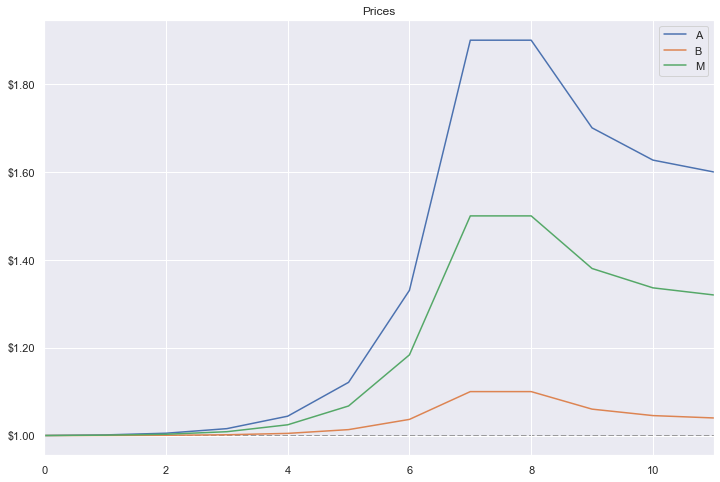

<AxesSubplot:title={'center':'Prices'}>

In [207]:
px = pd.DataFrame(
    {
        "A": pd.concat([_get_px_bridge(1, 1.90), _get_px_bridge(1.90, 1.60, t0=8, span=4)]),
        "B": pd.concat([_get_px_bridge(1, 1.10), _get_px_bridge(1.10, 1.04, t0=8, span=4)]),
    }
)
px.loc[:, "M"] = px.mean(axis="columns")
fc.plot(
    px,
    ydollar=True,
    axhline_locs=(1,),
    axhline_styles=("--",),
    title="Prices",
)